# **Preprocessing**

# Import Library

In [1]:
!python -m pip show albumentations

In [ ]:
import os
import random
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from glob import glob

import tensorflow as tf
import json

from collections import Counter
from PIL import Image, ImageEnhance, ImageFilter, ImageOps
import matplotlib.patches as mpatches
import albumentations as A
import cv2

In [4]:
IMG_SIZE = (256, 256)
INPUT_DIR = "datasets/AeBAD"
OUT_DIR = "datasets/dataset_split"

In [5]:
# Mengambil nama-nama kelas dari direktori
CLASS_NAMES = ['ablation', 'breakdown', 'fracture', 'groove']

# Membuat mapping dari nama kelas ke indeks
CLASS_TO_INDEX = {name: index for index, name in enumerate(CLASS_NAMES)}

# Menghitung jumlah kelas
NUM_CLASSES = len(CLASS_NAMES) + 1

# EDA

In [6]:
# Menghitung jumlah gambar per kelas
def count_images_per_class(input_dir):
    class_counts = Counter()
    
    for class_name in CLASS_NAMES:
        class_dir = os.path.join(input_dir, "images", class_name)
        if os.path.exists(class_dir):
            count = len([f for f in os.listdir(class_dir) if f.endswith(".png") and not f.startswith(".")])
            class_counts[class_name] = count
        else:
            class_counts[class_name] = 0
    return class_counts

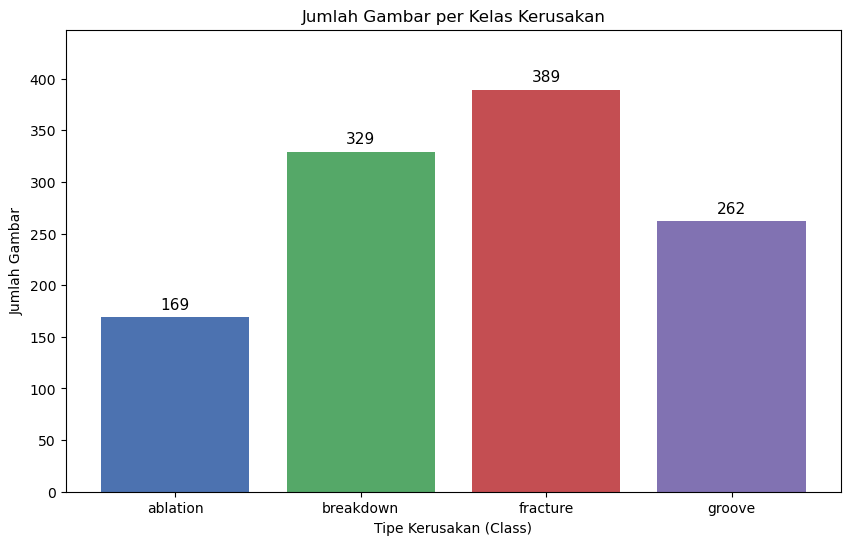

In [7]:
# Menghitung jumlah gambar per kelas
image_counts = count_images_per_class(INPUT_DIR)

class_names = list(image_counts.keys())
counts = list(image_counts.values())

plt.figure(figsize=(10, 6))
bars = plt.bar(class_names, counts, color=['#4c72b0', '#55a868', '#c44e52', '#8172b2'])

plt.xlabel("Tipe Kerusakan (Class)")
plt.ylabel("Jumlah Gambar")
plt.title("Jumlah Gambar per Kelas Kerusakan")
plt.ylim(0, max(counts) * 1.15) # Memberi ruang di atas bar tertinggi

# Menambahkan label
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 5, int(yval), ha='center', va='bottom', fontsize=11)

plt.show()


# Data Preparation

## Makes directory

In [ ]:
def make_dirs(root):
    for split in ['train', 'val', 'test']:
        os.makedirs(os.path.join(root, split, 'images'), exist_ok=True)
        os.makedirs(os.path.join(root, split, 'masks'), exist_ok=True)

In [ ]:
make_dirs(OUT_DIR)

## Split Data

In [ ]:
# Utilitas: Salin dan resize gambar
def copy_and_resize(src, dst, size=IMG_SIZE):
    img = Image.open(src).convert("RGB")
    img = img.resize(size)
    os.makedirs(os.path.dirname(dst), exist_ok=True)
    img.save(dst)

In [ ]:
# Mapping nama subset ke label integer
def get_class_label_from_name(name):
    for idx, subset in enumerate(CLASS_NAMES):
        if subset in name:
            return idx + 1  # label background = 0
    return 0

In [ ]:
# Proses dan simpan satu data split
def save_split(split_name, split_data, out_dir):
    for src_img, src_mask, name in split_data:        
        # Path tujuan
        dst_img = os.path.join(out_dir, split_name, "images", name)
        dst_mask = os.path.join(out_dir, split_name, "masks", name)

        # Simpan gambar
        copy_and_resize(src_img, dst_img)

        # Proses dan simpan mask
        mask = Image.open(src_mask).convert("L").resize(IMG_SIZE, Image.NEAREST)
        mask_np = np.array(mask)

        # Mapping nilai mask: ubah semua nilai >0 menjadi label kelas
        label_val = get_class_label_from_name(name)
        mask_np = np.where(mask_np > 0, label_val, 0).astype(np.uint8)

        os.makedirs(os.path.dirname(dst_mask), exist_ok=True)
        Image.fromarray(mask_np).save(dst_mask)

In [ ]:
def split_dir(input_dir, out_dir, val_ratio, test_ratio, seed=42):
    random.seed(seed)  # Pastikan hasil acak tetap

    train_set, val_set, test_set = [], [], []

    for subset in CLASS_NAMES:
        images_dir = os.path.join(input_dir, "images", subset)
        masks_dir = os.path.join(input_dir, "masks", subset)

        if not os.path.exists(images_dir) or not os.path.exists(masks_dir):
            continue

        mask_map = {
            f: os.path.join(root, f)
            for root, _, files in os.walk(masks_dir)
            for f in files
            if f.endswith(".png") and not f.startswith(".")
        }

        class_pairs = []
        for root, _, files in os.walk(images_dir):
            for f in files:
                if f.endswith(".png") and not f.startswith(".") and f in mask_map:
                    src_img = os.path.join(root, f)
                    src_mask = mask_map[f]
                    prefix = f"{subset}_{f}"
                    class_pairs.append((src_img, src_mask, prefix))

        random.shuffle(class_pairs)
        n_total = len(class_pairs)
        n_test = int(n_total * test_ratio)
        n_val = int(n_total * val_ratio)

        test_set += class_pairs[:n_test]
        val_set += class_pairs[n_test:n_test + n_val]
        train_set += class_pairs[n_test + n_val:]

    print(f"Total samples — Train: {len(train_set)}, Val: {len(val_set)}, Test: {len(test_set)}")

    save_split("train", train_set, out_dir)
    save_split("val", val_set, out_dir)
    save_split("test", test_set, out_dir)

    # Simpan log split
    split_log = {
        "train": [{"name": name, "label": get_class_label_from_name(name)} for _, _, name in train_set],
        "val":   [{"name": name, "label": get_class_label_from_name(name)} for _, _, name in val_set],
        "test":  [{"name": name, "label": get_class_label_from_name(name)} for _, _, name in test_set]
    }

    os.makedirs(out_dir, exist_ok=True)
    log_path = os.path.join(out_dir, "split_log.json")
    with open(log_path, "w") as f:
        json.dump(split_log, f, indent=2)

    print(f"✅ Dataset split completed. Log saved to {log_path}")

In [ ]:
split_dir(INPUT_DIR, OUT_DIR, val_ratio=0.2, test_ratio=0.1)

In [12]:
# Path ke folder augmented images dan masks
img_dir = "datasets/dataset_split/test/images"
mask_dir = "datasets/dataset_split/test/masks"

# Warna overlay untuk setiap kelas (RGBA)
overlay_colors = {
    'ablation': (1, 0, 0, 0.4),      # Merah
    'breakdown': (0, 1, 0, 0.4),     # Hijau
    'fracture': (0, 0, 1, 0.4),      # Biru
    'groove': (1, 1, 0, 0.4),        # Kuning
}

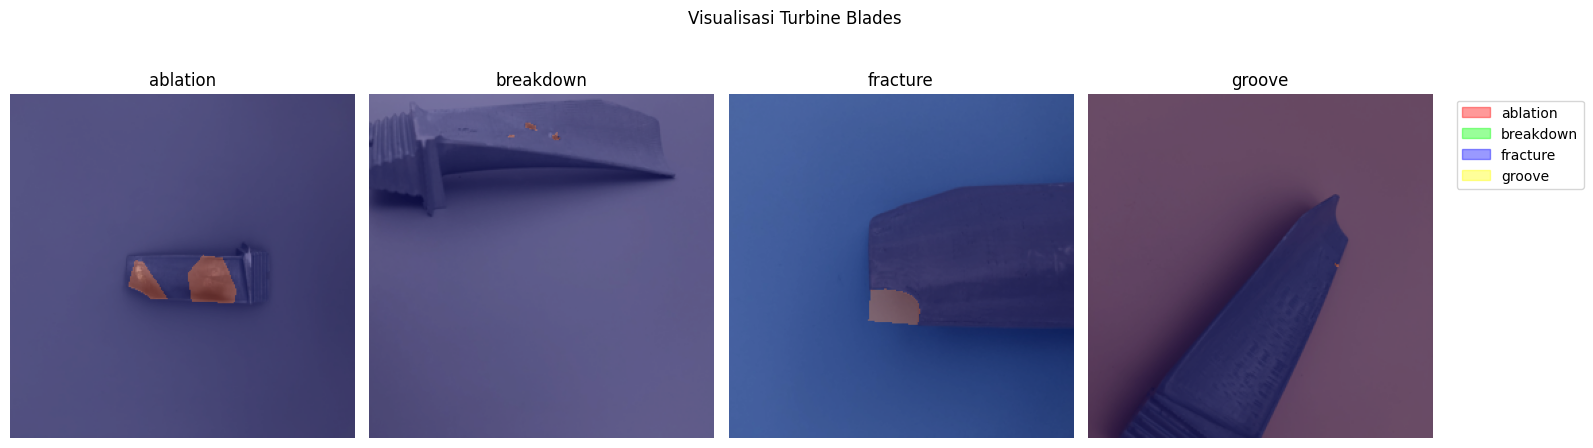

In [13]:
fig, axs = plt.subplots(1, len(CLASS_NAMES), figsize=(16, 5))

for i, cls in enumerate(CLASS_NAMES):
    # Cari satu file contoh untuk kelas ini
    img_file = next((f for f in os.listdir(img_dir) if f.startswith(cls) and f.endswith(".png")), None)
    mask_file = img_file  # Nama file mask sama dengan gambar

    if img_file and os.path.exists(os.path.join(mask_dir, mask_file)):
        img = np.array(Image.open(os.path.join(img_dir, img_file)).convert("RGB"))
        mask = np.array(Image.open(os.path.join(mask_dir, mask_file)))

        axs[i].imshow(img)
        # Overlay mask (mask==label)
        axs[i].imshow((mask > 0), cmap='gray', alpha=0.2)  # transparan abu-abu
        axs[i].imshow((mask == (i+1)), cmap='jet', alpha=0.4)  # overlay warna kelas

        axs[i].set_title(cls)
        axs[i].axis('off')
    else:
        axs[i].set_title(f"{cls}\n(no image)")
        axs[i].axis('off')

# Legend manual
patches = [mpatches.Patch(color=overlay_colors[cls], label=cls) for cls in CLASS_NAMES]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.suptitle("Visualisasi Turbine Blades")
plt.tight_layout()
plt.show()

### Distribusi kelas

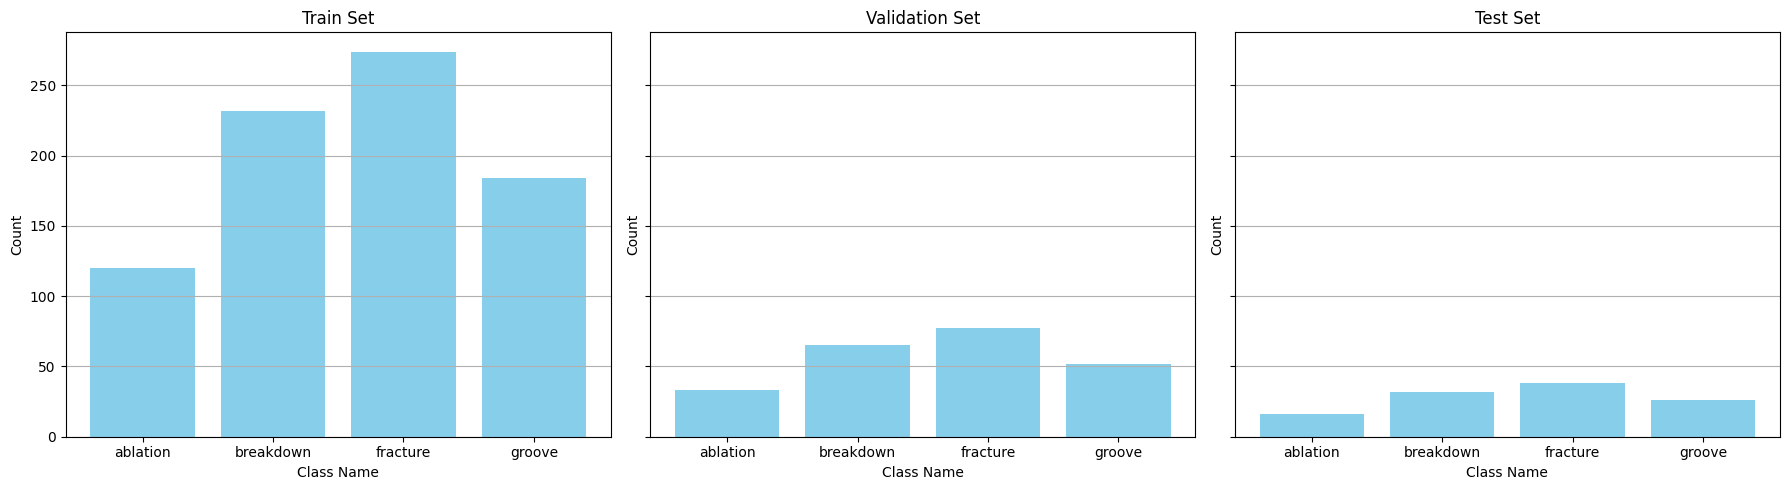

In [14]:
# Load the split_log.json file
with open("datasets/dataset_split/split_log.json", "r") as f:
    split_log = json.load(f)

# Count label distribution in each split
def count_labels(split_data):
    labels = [item["label"] for item in split_data]
    return dict(Counter(labels))

# Get label distributions
train_dist = count_labels(split_log["train"])
val_dist = count_labels(split_log.get("val", []))
test_dist = count_labels(split_log.get("test", []))

# Ubah label angka menjadi nama kelas untuk plot
label_to_name = {i + 1: name for i, name in enumerate(CLASS_NAMES)}

fig, axs = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
splits = [("Train", train_dist), ("Validation", val_dist), ("Test", test_dist)]

for i, (title, dist) in enumerate(splits):
    # Mapping label ke nama kelas
    class_labels = [label_to_name.get(k, "Unknown") for k in sorted(dist.keys())]
    counts = [dist[k] for k in sorted(dist.keys())]
    axs[i].bar(class_labels, counts, color='skyblue')
    axs[i].set_title(f"{title} Set")
    axs[i].set_xlabel("Class Name")
    axs[i].set_ylabel("Count")
    axs[i].set_xticks(class_labels)
    axs[i].grid(True, axis='y')

plt.tight_layout()
plt.show()


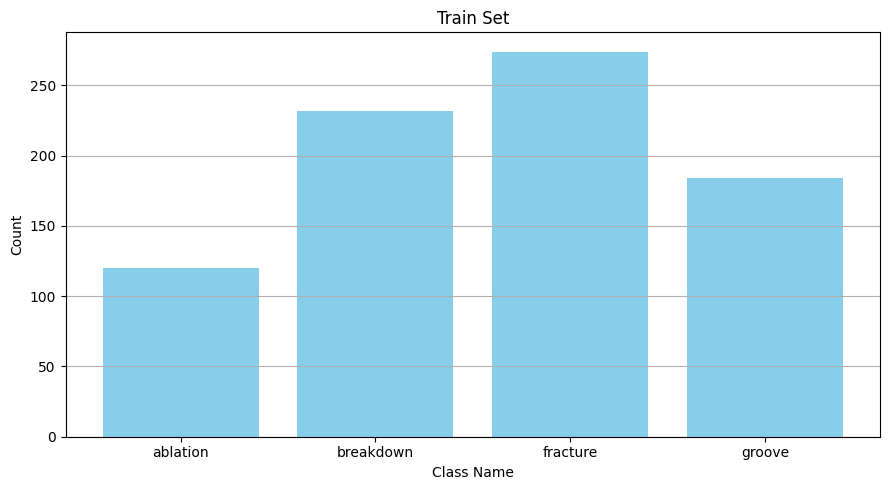

In [15]:
# Ubah label angka menjadi nama kelas untuk plot
label_to_name = {i + 1: name for i, name in enumerate(CLASS_NAMES)}

fig, axs = plt.subplots(1, 1, figsize=(9, 5), sharey=True)
splits = [("Train", train_dist)]

for i, (title, dist) in enumerate(splits):
    # Mapping label ke nama kelas
    class_labels = [label_to_name.get(k, "Unknown") for k in sorted(dist.keys())]
    counts = [dist[k] for k in sorted(dist.keys())]
    axs.bar(class_labels, counts, color='skyblue')
    axs.set_title(f"{title} Set")
    axs.set_xlabel("Class Name")
    axs.set_ylabel("Count")
    axs.set_xticks(class_labels)
    axs.grid(True, axis='y')

plt.tight_layout()
plt.show()

## Augmentasi

In [8]:
import os
import shutil
import numpy as np
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm

In [9]:
# Direktori
INPUT_IMG_DIR = "datasets/dataset_split/train/images"
INPUT_MASK_DIR = "datasets/dataset_split/train/masks"
OUTPUT_IMG_DIR = "datasets/dataset_split/aug-train/images"
OUTPUT_MASK_DIR = "datasets/dataset_split/aug-train/masks"

# Create directory
os.makedirs(OUTPUT_IMG_DIR, exist_ok=True)
os.makedirs(OUTPUT_MASK_DIR, exist_ok=True)

# Konfigurasi
PATCH_SIZE = 256
AUGMENTATION_TIMES = 3

### Augmentasi 1

In [10]:
import numpy as np
import cv2
import os
import albumentations as A
from tqdm import tqdm

In [11]:
# Transformasi augmentasi khusus minor class
minor_class_aug = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=20, p=0.5),
    A.ElasticTransform(alpha=1, sigma=50, alpha_affine=20, p=0.3),
    A.RandomBrightnessContrast(p=0.3),
    A.RandomCrop(height=128, width=128, p=0.4),  # fokus area
    A.Resize(256, 256)
])

C:\Users\MyBook Hype\AppData\Local\Temp\ipykernel_7300\3397571252.py:6: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(alpha=1, sigma=50, alpha_affine=20, p=0.3),


In [12]:
def contains_minor_class(mask, minor_labels={3, 4}):
    return np.any(np.isin(mask, list(minor_labels)))

In [13]:
def augment_and_copy_all(image_dir, mask_dir, save_img_dir, save_mask_dir, n_aug=3):
    image_files = sorted(os.listdir(image_dir))

    for fname in tqdm(image_files):
        # Baca gambar dan mask
        img = cv2.imread(os.path.join(image_dir, fname))
        mask = cv2.imread(os.path.join(mask_dir, fname), cv2.IMREAD_GRAYSCALE)

        # Simpan versi asli
        cv2.imwrite(os.path.join(save_img_dir, fname), img)
        cv2.imwrite(os.path.join(save_mask_dir, fname), mask)

        # Cek jika mengandung groove atau fracture
        if contains_minor_class(mask):
            for i in range(n_aug):
                augmented = minor_class_aug(image=img, mask=mask)
                aug_img = augmented["image"]
                aug_mask = augmented["mask"]

                # Simpan hasil augmentasi
                new_fname = f"{os.path.splitext(fname)[0]}_aug{i}.png"
                cv2.imwrite(os.path.join(save_img_dir, new_fname), aug_img)
                cv2.imwrite(os.path.join(save_mask_dir, new_fname), aug_mask)

In [14]:
augment_and_copy_all(INPUT_IMG_DIR, INPUT_MASK_DIR, OUTPUT_IMG_DIR, OUTPUT_MASK_DIR, n_aug=3)

100%|██████████| 810/810 [00:57<00:00, 14.11it/s]


## Visualisasi setelah augmentasi

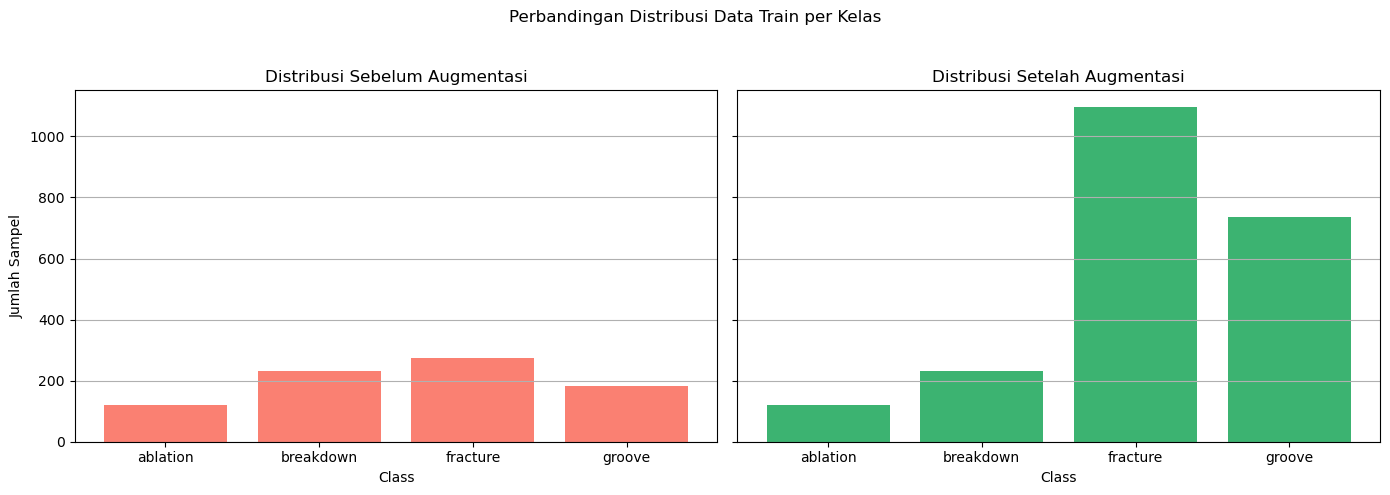

In [20]:
# Path lokal ke folder train dan augmented
train_dir = "datasets/dataset_split/train/images"
aug_dir = "datasets/dataset_split/aug-train/images"

# Hitung distribusi sebelum augmentasi
train_files = [f for f in os.listdir(train_dir) if f.endswith(".png")]
train_counts = Counter([f.split("_")[0] for f in train_files])

# Hitung distribusi setelah augmentasi
aug_files = [f for f in os.listdir(aug_dir) if f.endswith(".png")]
aug_counts = Counter([f.split("_")[0] for f in aug_files])

# Ambil semua kelas yang unik dari kedua distribusi
all_classes = sorted(set(train_counts.keys()) | set(aug_counts.keys()))

# Ambil nilai jumlah untuk setiap kelas
train_values = [train_counts.get(cls, 0) for cls in all_classes]
aug_values = [aug_counts.get(cls, 0) for cls in all_classes]

# Plot perbandingan
fig, axs = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

axs[0].bar(all_classes, train_values, color='salmon')
axs[0].set_title("Distribusi Sebelum Augmentasi")
axs[0].set_xlabel("Class")
axs[0].set_ylabel("Jumlah Sampel")
axs[0].grid(axis='y')

axs[1].bar(all_classes, aug_values, color='mediumseagreen')
axs[1].set_title("Distribusi Setelah Augmentasi")
axs[1].set_xlabel("Class")
axs[1].grid(axis='y')

plt.suptitle("Perbandingan Distribusi Data Train per Kelas")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [21]:
aug_values

[120, 232, 1096, 736]

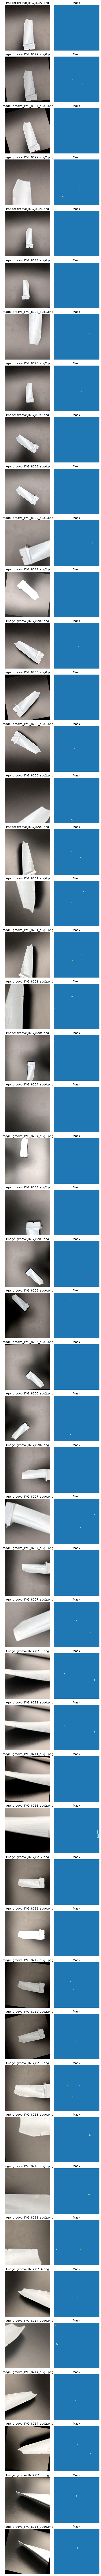

In [23]:
# Visualisasi beberapa contoh image dan mask untuk kelas 'groove'
n_samples = 50
groove_files = [f for f in aug_files if f.startswith('groove')]
sample_files = groove_files[:n_samples]

fig, axs = plt.subplots(n_samples, 2, figsize=(6, 3 * n_samples))

for i, fname in enumerate(sample_files):
    img_path = os.path.join(aug_dir, fname)
    mask_path = os.path.join(OUTPUT_MASK_DIR, fname)

    img = np.array(Image.open(img_path).convert("RGB"))
    mask = np.array(Image.open(mask_path))

    axs[i, 0].imshow(img)
    axs[i, 0].set_title(f"Image: {fname}")
    axs[i, 0].axis('off')

    axs[i, 1].imshow(mask, cmap='tab20', vmin=0, vmax=len(CLASS_NAMES))
    axs[i, 1].set_title("Mask")
    axs[i, 1].axis('off')

plt.tight_layout()
plt.show()